# Infomap Community Detection

In [57]:
import pandas as pd
import fractions
import igraph as ig
import networkx as nx
import random
import matplotlib.pyplot as plt

### NetworkX Graph Creation

Creation with edge attributes, no dataframe tweaking needed

In [108]:
edge_df = pd.read_csv('data/coauthor_edge_list.csv')
edge_df.head()

,Author ID,Name,Country,Author Publication Count,Publication Coauthors,Coauthor ID
0,88660066,"Antinori, A",Italy,1,13,88687508
1,88693999,"Antinori, A",Italy,1,13,88687508
2,88696885,"Antinori, A",Italy,1,13,88687508
3,88696886,"Antinori, A",Italy,1,13,88687508
4,88693998,"Antinori, A",Italy,1,13,88687508


In [107]:
G_nx = nx.from_pandas_edgelist(edge_df, source='Author ID', target="Coauthor ID", edge_attr='Publication Coauthors')
print(nx.info(G_nx))

Graph with 260637 nodes and 2024546 edges


In [100]:
print(nx.info(G_nx))

Graph with 260637 nodes and 2024546 edges


#### Arranging *node* data for Graph
Using the dictionary of Coauthors, isolate node data with feature/attribute: Name, Country, PubNum (total number of each author's COVID-19 publications)

In [115]:
node_df = pd.read_csv('data/author_node_list.csv', index_col=0)
node_df.head()

,Name,Country,Author Publication Count
88687508,"Antinori, A",Italy,1
88660066,"Notari, S",Italy,1
88693999,"Cicalini, Stefania",Italy,2
88696885,"Agrati, Chiara",Italy,12
88696886,"Campioni, Paolo",Italy,2


Creating dictionaries of this data and add to network as node attributes

In [116]:
node_dict = node_df.to_dict(orient='dict')
node_dict_name = node_dict['Name']
node_dict_pubtotal = node_dict['Author Publication Count']
node_dict_country = node_dict['Country']

In [117]:
# Adding note attributes
nx.set_node_attributes(G_nx, node_dict_name, name='Name')
nx.set_node_attributes(G_nx, node_dict_pubtotal, name='Author Pub Count')
nx.set_node_attributes(G_nx, node_dict_country, name='Country')

### Conversion to iGraph 
(creation of igraph directly from dataframe lead to a very low modularity score (~0.07) of communities)

In [119]:
G_ig = ig.Graph.from_networkx(G_nx)

In [120]:
print(G_ig.summary())

IGRAPH U--- 260637 2024546 -- 
+ attr: Author Pub Count (v), Country (v), Name (v), _nx_name (v), Publication Coauthors (e)


## Infomap Community Detection

In [121]:
random.seed(123)
c_infomap = G_ig.community_infomap(trials=4)
print(c_infomap.summary())
print(c_infomap.modularity)

Clustering with 260637 elements and 23797 clusters
0.8715941275568821


### Plotting Infomap Communities

plot the community sizes

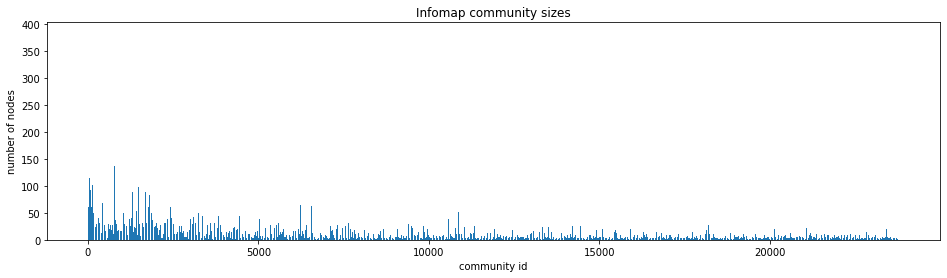

In [49]:
infomap_sizes = c_infomap.sizes()
#infomap_sizes.sort(reverse=True)
plt.figure(figsize=(16,4))
plt.title("Infomap community sizes")
plt.xlabel("community id")
plt.ylabel("number of nodes")
plt.bar(list(range(1, len(infomap_sizes) + 1)), infomap_sizes)
plt.show()

plot the distribution (historgram) of community sizes

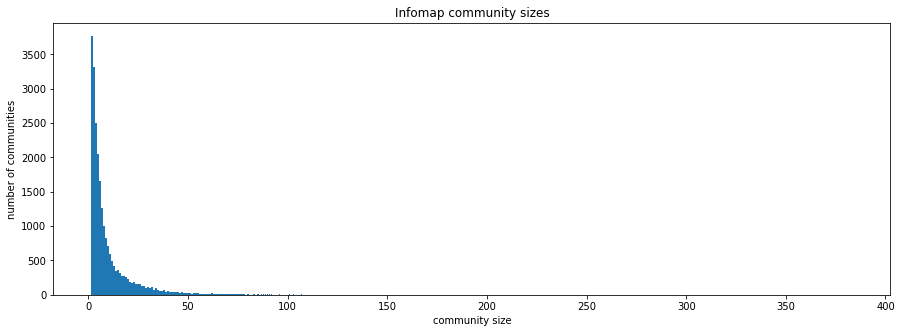

In [39]:
infomap_sizes = c_infomap.sizes()

infomap_hist = []
for i in range(min(infomap_sizes), max(infomap_sizes)):
    count = infomap_sizes.count(i)
    infomap_hist.append(count)
    
#infomap_sizes.sort(reverse=True)
plt.figure(figsize=(16,5))
plt.title("Infomap community sizes")
plt.xlabel("community size")
plt.ylabel("number of communities")
plt.bar(list(range(min(infomap_sizes), max(infomap_sizes))), infomap_hist)
plt.show()

## Store node community membership

Create Dictionary of Infomap community membership for later comparisons with GraphSAGE clustering

In [133]:
infomap_id_dict = dict(zip(list(G_nx.nodes()), c_infomap.membership))

In [136]:
infomap_id_df = pd.DataFrame.from_dict(infomap_id_dict, orient='index')
infomap_id_df.to_csv('data/infomap_community_id.csv', index=True)

### Visualizing a single community cluster
apply Infomap membership to original networkx Graph as a node attribute

In [124]:
nx.set_node_attributes(G_nx, infomap_com_dict, "c_infomap")

In [125]:
com_id = 12 # select the community id

# extraction of a subgraph from the nodes in this community
com_g = G_nx.subgraph(
    [n for n, attrdict in G_nx.nodes.items() if attrdict["c_infomap"] == com_id]
)
print(nx.info(com_g))

Graph with 10 nodes and 25 edges


Creating label dictionaries for community structure plot

In [126]:
name_labels = nx.get_node_attributes(com_g, 'Name')
country_labels = nx.get_node_attributes(com_g, 'Country')
labels_combined = {}
for i in name_labels:
    labels_combined[i] = str(name_labels[i]) + "\n" + str(country_labels[i])

Plotting the community

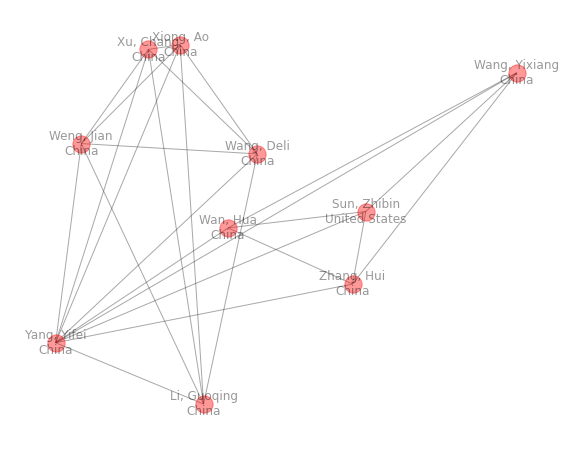

In [127]:
# plot community structure only
pos = nx.random_layout(com_g, seed=123)
plt.figure(figsize=(10, 8))
nx.draw_networkx(com_g, pos, edge_color="#26282b", node_color="red", alpha=0.4, labels=labels_combined)
plt.axis("off")
plt.show()